# Is it a banger?

In [68]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline

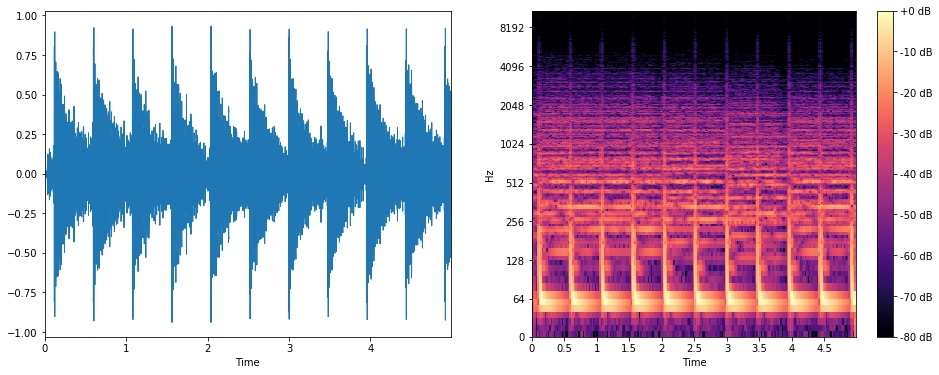

In [25]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
librosa.display.waveplot(raw_sounds[10], sr=22050)

plt.subplot(1, 2, 2)
D = librosa.logamplitude(np.abs(librosa.stft(raw_sounds[10]))**2, ref_power=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

In [30]:
D.dtype

dtype('float32')

In [27]:
training_data_glob = '../data/not_a_banger/*.wav'
sound_file_paths = glob.glob(training_data_glob)
raw_sounds = load_sound_files(sound_file_paths, 22050)
%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


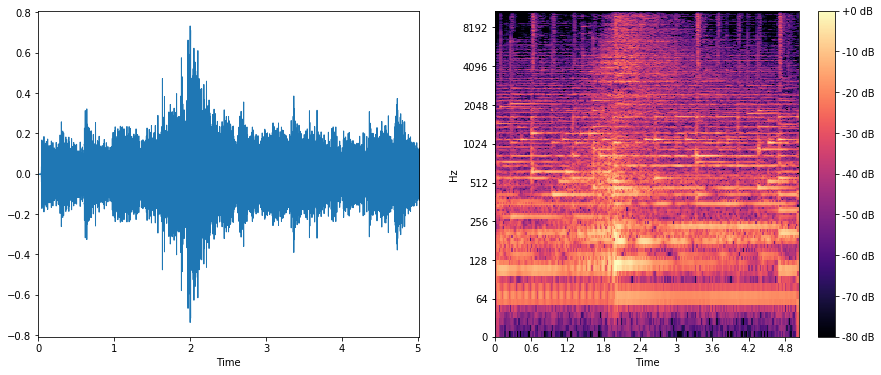

In [29]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
librosa.display.waveplot(raw_sounds[14], sr=22050)

plt.subplot(1, 2, 2)
D = librosa.logamplitude(np.abs(librosa.stft(raw_sounds[14]))**2, ref_power=np.max)
librosa.display.specshow(D, x_axis='time',y_axis='log')
plt.colorbar(format='%+2.0f dB')

In [140]:
parent_dir = '../data'
parent_dir_contents = [os.path.join(parent_dir, dirname) for dirname in os.listdir(parent_dir)]
sub_dirs = [filename if os.path.isdir(filename) else None for filename in parent_dir_contents]
sub_dirs = list(filter(None.__ne__, sub_dirs))
labels_list = [os.path.relpath(path, parent_dir) for path in sub_dirs]
print(sub_dirs)
print(labels)

['../data/banger', '../data/not_a_banger']
['banger', 'not_a_banger']


In [130]:
def extract_feature(file_name, sample_rate=22050):
    audio, sample_rate = librosa.load(file_name, sr=sample_rate)
    log_specgram = librosa.logamplitude(np.abs(librosa.stft(audio))**2, ref_power=np.max)
    features = {"audio": audio, "log_specgram": log_specgram}
    return features

def one_hot_encode(label, labels_list):
    n_labels = len(labels_list)
    one_hot_encoded = np.zeros(n_labels)
    for idx, cmp in enumerate(labels_list):
        if label == cmp:
            one_hot_encoded[idx] = 1                     
    return one_hot_encoded

def trim_file_list(fnames_list, p_include=1.0):
    fnames_list = np.asarray(fnames_list)
    include = np.random.rand(*fnames_list.shape)
    fnames_list = fnames_list[include < p_include]
    return fnames_list
    

def parse_audio_files(parent_dir, sub_dirs_list, labels_list, file_ext='*.wav', p_include=1.0):
    data = []
    index = []
    for label_idx, sub_dir in enumerate(sub_dirs_list):
        fnames_list = glob.glob(os.path.join(sub_dir, "*.wav"))
        fnames_list = trim_file_list(fnames_list, p_include=p_include)
        for fname in fnames_list:
            print("Processing " + os.path.basename(fname))
            features = extract_feature(fname)
            label = labels_list[label_idx]
            label_one_hot = one_hot_encode(label, labels_list)
            features['label'] = labels_list[label_idx]
            features["label_one_hot"] = label_one_hot
            data.append(features)
            index.append(os.path.basename(fname))
    return pd.DataFrame(data, index=index)

In [134]:
df = parse_audio_files(parent_dir, sub_dirs, labels_list, p_include=0.2)
df.to_pickle(os.path.join(parent_dir, 'processed_dataset.pkl'))

Processing 808 State - In Yer Face (Bicep Remix)002.wav
Processing 808 State - In Yer Face (Bicep Remix)006.wav
Processing 808 State - In Yer Face (Bicep Remix)010.wav
Processing 808 State - In Yer Face (Bicep Remix)014.wav
Processing 808 State - In Yer Face (Bicep Remix)019.wav
Processing 808 State - In Yer Face (Bicep Remix)020.wav
Processing 808 State - In Yer Face (Bicep Remix)024.wav
Processing 808 State - In Yer Face (Bicep Remix)031.wav
Processing 808 State - In Yer Face (Bicep Remix)037.wav
Processing 808 State - In Yer Face (Bicep Remix)039.wav
Processing 808 State - In Yer Face (Bicep Remix)042.wav
Processing 808 State - In Yer Face (Bicep Remix)062.wav
Processing 808 State - In Yer Face (Bicep Remix)063.wav
Processing 808 State - In Yer Face (Bicep Remix)070.wav
Processing 808 State - In Yer Face (Bicep Remix)073.wav
Processing 808 State - In Yer Face (Bicep Remix)076.wav
Processing 808 State - In Yer Face (Bicep Remix)077.wav
Processing 808 State - In Yer Face (Bicep Remix)

In [139]:
df.iloc[0]["audio"]

array([ 0.        ,  0.        ,  0.        , ..., -0.01429847,
       -0.01556006, -0.0168819 ], dtype=float32)